# Import Libraries

In [1]:
# data manipulation
import pandas as pd

# numpy arrays
import numpy as np

# data visualization
import seaborn as sns

import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

sns.set()

# NLP
import string

import spacy
from spacy.tokens.doc import Doc
from spacy.matcher import Matcher

from wordcloud import WordCloud

import nltk
from nltk.probability import FreqDist

import re

# machine learning
from sklearn.datasets import fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression     # Logistic Regression
from sklearn.naive_bayes import MultinomialNB           # Naive Bayes
from sklearn.svm import LinearSVC                       # SVM
from sklearn.ensemble import RandomForestClassifier     # Random Forest

from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# TODO:
# install the latest version of `sklearn` to use `plot_confusion_matrix` 
# from sklearn.metrics import plot_confusion_matrix

# Model explainability
import shap
from lime.lime_text import LimeTextExplainer

# other
from pprint import pprint
from time import time
import logging

# load english model
nlp = spacy.load('en_core_web_md')

/home/resaln/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/resaln/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/resaln/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Helper Functions

In [2]:
def get_n_color_palette(palette_name, n_colors, as_hex=False):
    palette = sns.color_palette(palette=palette_name, n_colors=n_colors)
    if as_hex:
        palette = palette.as_hex()
    palette.reverse()
    return palette

# Load and Prepare Data

For faster execution times, select subset of the categories out of the 20 categories

In [3]:
# subset_categories = ['alt.atheism', 'soc.religion.christian',
#                      'comp.graphics', 'sci.med']
subset_categories = ['alt.atheism', 'talk.religion.misc', 'sci.med']

In [4]:
newsgroups_data = fetch_20newsgroups(subset='all', categories=subset_categories)

In [5]:
categories = newsgroups_data.target_names

In [6]:
df = pd.DataFrame(data={
    'text': newsgroups_data.data,
    'category': newsgroups_data.target
})

In [7]:
df.shape

(2417, 2)

In [8]:
df['category'] = df['category'].apply(lambda x: categories[x])

In [9]:
df.head()

,text,category
0,From: Steve_Mullins@vos.stratus.com\nSubject: ...,alt.atheism
1,From: bobsarv@microsoft.com (Bob Sarver)\nSubj...,talk.religion.misc
2,From: jhilmer@ruc.dk (Jakob Hilmer)\nSubject: ...,sci.med
3,From: mccullou@snake2.cs.wisc.edu (Mark McCull...,alt.atheism
4,From: bobbe@vice.ICO.TEK.COM (Robert Beauchain...,alt.atheism


# What is this Data?

The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups.

The data is organized into 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. `comp.sys.ibm.pc.hardware` / `comp.sys.mac.hardware`), while others are highly unrelated (e.g `misc.forsale` / `soc.religion.christian`).

Here is a list of the 20 newsgroups, partitioned (more or less) according to subject matter:

<table style='font-family:"Courier New", Courier, monospace; font-size:80%'>
    <tr>
        <td>comp.graphics<br>comp.os.ms-windows.misc<br>comp.sys.ibm.pc.hardware<br>comp.sys.mac.hardware<br>comp.windows.x
        </td>
        <td>rec.autos<br>rec.motorcycles<br>rec.sport.baseball<br>rec.sport.hockey</td>
        <td>sci.crypt<br>sci.electronics<br>sci.med<br>sci.space</td>
    </tr>
    <tr>
        <td>misc.forsale</td>
        <td>talk.politics.misc<br>talk.politics.guns<br>talk.politics.mideast</td>
        <td>talk.religion.misc<br>alt.atheism<br>soc.religion.christian</td>
    </tr>
</table>

# Data Statistics

One quick *data-cleaning* step is to rename the category column, and use only the last part (`atheism`, `christian`, ...)

In [10]:
# df = df.assign(category=df['category'].apply(lambda x: x.split('.')[-1]))
# disable this cell temporairly, and figure out later the best way to name categories

In [11]:
# df.head()

In [12]:
categories_statistics_df = df.groupby(by='category')['text'].agg({
                                'count': lambda x: x.size,
                                'mean': lambda x: x.str.len().mean(),
                                'max': lambda x: x.str.len().max(),
                                'min': lambda x: x.str.len().min()
                            })\
                            .reset_index()\
                            .sort_values(by='count', ascending=False)

using a dict on a Series for aggregation
is deprecated and will be removed in a future version


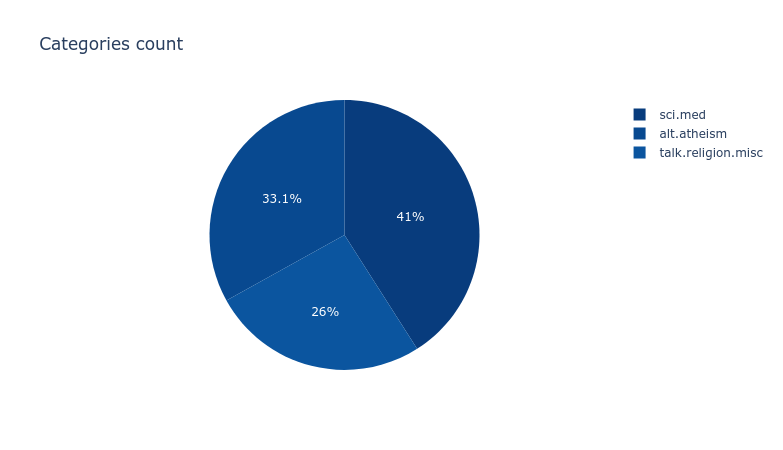

In [13]:
fig = px.pie(data_frame=categories_statistics_df, names='category', values='count',
            color_discrete_sequence=get_n_color_palette('Blues', 20, True),
            title='Categories count')
fig.show()

It's obvious that the dataset is *balanced*

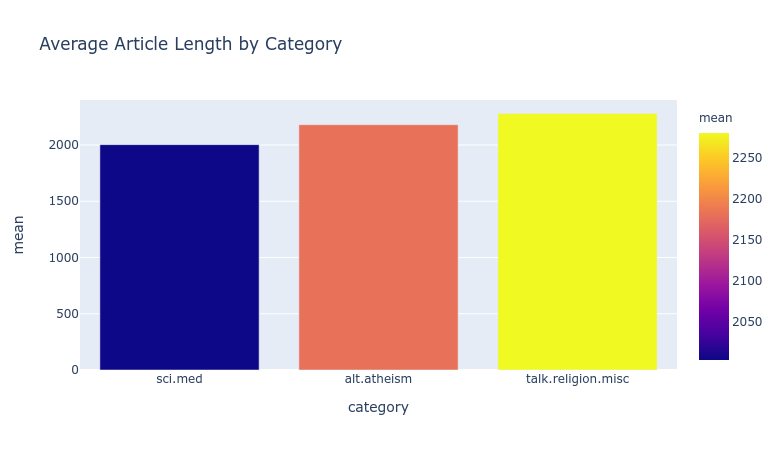

In [14]:
fig = px.bar(data_frame=categories_statistics_df.sort_values(by='mean'), x='category', y='mean',
            color='mean', title='Average Article Length by Category')
fig.show()

This chart shows how long the *polictics* articles, compared to *computer* articles

# Word Cloud

In [15]:
en_stop_words = nlp.Defaults.stop_words

In [16]:
categories_text_df = df.groupby(by='category')\
                        .agg({
                            'text': ' '.join
                        })\
                        .reset_index()

In [17]:
categories_text_df

,category,text
0,alt.atheism,From: Steve_Mullins@vos.stratus.com\nSubject: ...
1,sci.med,From: jhilmer@ruc.dk (Jakob Hilmer)\nSubject: ...
2,talk.religion.misc,From: bobsarv@microsoft.com (Bob Sarver)\nSubj...


In [18]:
def plot_word_cloud(category_name, category_text):
    plt.subplots(figsize = (8,8))
    wc = WordCloud(background_color="white", stopwords=en_stop_words, width=1000, height=600)
    wc.generate(category_text)
    plt.title(label=category_name)
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
    plt.show()

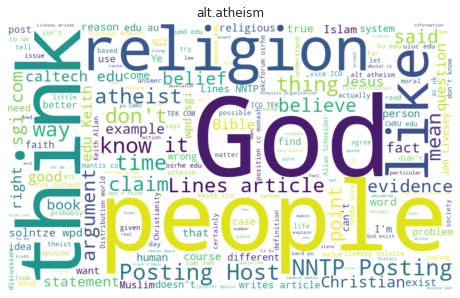

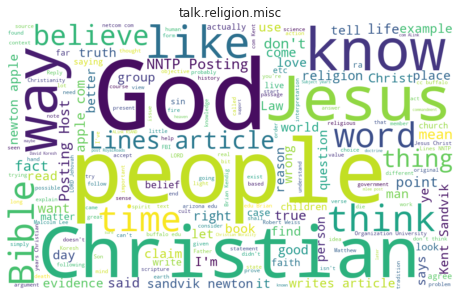

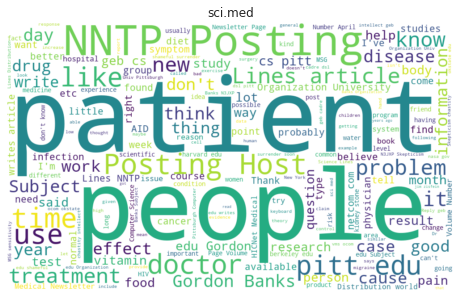

In [19]:
for category in df['category'].unique():
    plot_word_cloud(category,
                    categories_text_df[categories_text_df['category'] == category]['text'].values[0])

# Split the data

In [20]:
X = df['text']
y = df['category']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Text Vectorization

In [22]:
def is_clean_token(token):
    return (
        not token.is_stop                   # remove stop words
        and not token.is_digit              # remove digits
        and not token.like_num              # remove numbers
        and not token.like_email            # remove emails
        and not token.like_url              # remove URLs
        and token.is_alpha                  # keep only alphabetic tokens
        and token.is_ascii                  # keep only ascii tokens
        and len(token.lemma_.lower()) > 2   # keep only token which has length greater than two letters
    )

**Note**: disabling the *parser* and the *named entity recognizer* components, make the processing of the document much more efficient, and it's advised according to the [Documentation](https://spacy.io/usage/processing-pipelines#disabling) 

In [23]:
def spacy_analyzer(document):
    
    # apply the language pipeline on the passed document
    # for quicker execution, disable `parser` and `ner` pipeline steps
    doc = nlp(document, disable=['parser', 'ner'])
    
    # clean document
    tokens = [token.lemma_.lower() for token in doc if is_clean_token(token)] 
    
    return tokens

# Create Pipeline

In [73]:
# vectorizer = TfidfVectorizer(analyzer=spacy_analyzer, stop_words=en_stop_words,
#                              max_df=0.5, min_df=10, max_features=10000)
vectorizer = TfidfVectorizer(stop_words=en_stop_words,
                             max_df=0.5, min_df=10, max_features=10000)

# Logistic Regression classifier
lr_clf = LogisticRegression(C=1.0, solver='newton-cg', multi_class='multinomial')

# Naive Bayes classifier
nb_clf = MultinomialNB(alpha=0.01)

# SVM classifier
svm_clf = LinearSVC(C=1.0)

# Random Forest classifier
random_forest_clf = RandomForestClassifier(n_estimators=100, criterion='gini', 
                                           max_depth=50, random_state=0)

In [74]:
pipeline = Pipeline([
    ('vect', vectorizer),
    ('clf', lr_clf)
])

In [75]:
# %%time
# pipeline.fit(X_train, y_train)

In [76]:
# %%time
# y_pred = pipeline.predict(X_test)

# Hyper-parameters tunning

In [77]:
parameters = {
    # vectorizer hyper-parameters
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__max_df': [0.4, 0.5, 0.6],
    'vect__min_df': [10, 50, 100],
    'vect__max_features': [5000, 10000],
    'clf': [lr_clf, nb_clf, svm_clf, random_forest_clf]
}

In [ ]:
if __name__ == "__main__":
    
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
#     for param_name in sorted(parameters.keys()):
#         print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf': [LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False),
         MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True),
         LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0),
         RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min


In [72]:
grid_search.best_params_

{'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=50, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=0, verbose=0,
                        warm_start=False),
 'clf__criterion': 'gini',
 'clf__max_depth': 50,
 'clf__n_estimators': 100}

In [57]:
grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.5, max_features=10000,
                                 min_df=10, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'ac...
                                             'amount', 'an', 'and', 'another',
                                             'any', ...},
                                 strip_accents=None, sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+

# Evaluation

## Classification report:

In [ ]:
clf_report = classification_report(y_true=y_test, y_pred=y_pred,
                                   target_names=pipeline.named_steps.clf.classes_,
                                   output_dict=True)

In [ ]:
clf_report_df = pd.DataFrame(data=clf_report)

In [ ]:
clf_report_df

In [ ]:
clf_report_df.drop(index='support', inplace=True)

In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.heatmap(data=clf_report_df.T, annot=True, cmap='Blues', fmt='.2f', vmin=0, vmax=1)
plt.show()

## Confusion matrix:

In [ ]:
conf_matrix = confusion_matrix(y_true=y_test,
                     y_pred=y_pred,
                     labels=pipeline.named_steps.clf.classes_)

In [ ]:
conf_matrix_df = pd.DataFrame(data=conf_matrix, columns=pipeline.named_steps.clf.classes_,
                                index=pipeline.named_steps.clf.classes_)

In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.heatmap(data=conf_matrix_df, annot=True, cmap='RdPu', fmt='d')
plt.show()

# Features Importance

In [ ]:
logistic_regression = pipeline.named_steps['clf']

In [ ]:
feature_names = pipeline.named_steps['vect'].get_feature_names()

In [ ]:
def plot_features_importance(clf, feature_names, n_feature=15):
    '''
    this function takes the classifier object (assuming it has `coef_` attribute)
    the list of features, which we can get using the vectorizer,
    and the number of features we want to show
    it plots for each class label, the most positive and negative features, with their weight
    '''
    
    res = []
    
    for i, class_label in enumerate(clf.classes_):
        
        # get indices of top positive/negative coefficient
        negative_coefs_indices = np.argsort(clf.coef_[i])[:n_feature]
        positive_coefs_indices = np.argsort(clf.coef_[i])[-n_feature:]
        
        # get the coefficient values
        negative_coefs = [clf.coef_[i][coef_idx] for coef_idx in negative_coefs_indices]
        positive_coefs = [clf.coef_[i][coef_idx] for coef_idx in positive_coefs_indices]
        
        # get the corresponding features names of the top coefficient
        negative_features = [feature_names[coef_idx] for coef_idx in negative_coefs_indices]
        positive_features = [feature_names[coef_idx] for coef_idx in positive_coefs_indices]
        
        # stack arrays into one array
        coefs = np.hstack([negative_coefs, positive_coefs])
        features = np.hstack([negative_features, positive_features])
        
        res.append([features, coefs, class_label])    
        # plot feature names agains their weight, using bar plot
#         fig = px.bar(x=features, y=coefs, color=coefs, title=class_label)
#         fig.show()
    return res

**TODO**: make the function `plot_features_importance` more general, and move the code of plotting the charts to the function.
Hide legend in the plot, and rotate the feature names on the x-axis, so they would be horizontal.

In [ ]:
res = plot_features_importance(clf=clf, feature_names=feature_names)

In [ ]:
bar1, bar2, bar3, bar4 = res

In [ ]:
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=(bar1[2], bar2[2], bar3[2], bar4[2]))

fig.add_trace(
    go.Bar(x=bar1[0], y=bar1[1]),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=bar2[0], y=bar2[1]),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x=bar3[0], y=bar3[1]),
    row=2, col=1
)

fig.add_trace(
    go.Bar(x=bar4[0], y=bar4[1]),
    row=2, col=2
)

# Model Explainability

In [ ]:
explainer = LimeTextExplainer(class_names=pipeline.named_steps['clf'].classes_)

In [ ]:
idx = 1
print(f'Document id: {idx}')
print(f'Predicted class: {pipeline.predict([X_test.iloc[idx]])[0]}')
print(f'True class: {y_test.iloc[idx]}')

In [ ]:
exp_object = explainer.explain_instance(text_instance=X_test.iloc[idx],
                                       classifier_fn=pipeline.predict_proba,
                                       top_labels=2)

In [ ]:
exp_object.show_in_notebook()